# Домашнее задание по теме "Коллаборативная фильтрация"

***Цель работы:*** обучить модель и показать метрику RMSE на тестовой выборке не более 0.87

***План работы:***
    
1. Предобработка данных и EDA
2. Объединение таблиц
3. Обучение моделей

### Предобработка данных и EDA

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate
from six import iteritems

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection import GridSearchCV

In [4]:
movies = pd.read_csv('../data/movies.csv',header=None, sep='::', engine='python')
movies.columns = ['movieId', 'title', 'genres']
movies

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [6]:
rating = pd.read_csv('../data/ratings.csv',header=None, sep='::', engine='python')
rating.columns = ['userId', 'movieId', 'rating', 'timestamp']
rating

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [7]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [8]:
users = pd.read_csv('../data/users.csv',header=None, sep='::', engine='python')
users.columns = ['userId', 'gender', 'age', 'occupation', 'zip-code']
users

,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


Поскольку довольно глубокий анализ датасетов мы проводили в прошлый раз, в этот раз лишь перепроверим, изменилось ли что-то кроме величины таблицы rating:

<AxesSubplot:xlabel='rating', ylabel='Density'>

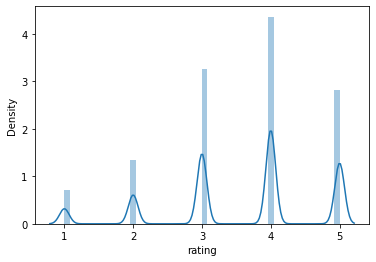

In [10]:
sns.distplot(rating['rating'])

Как и раньше, пользователи отдают предпочтение оценке 4.

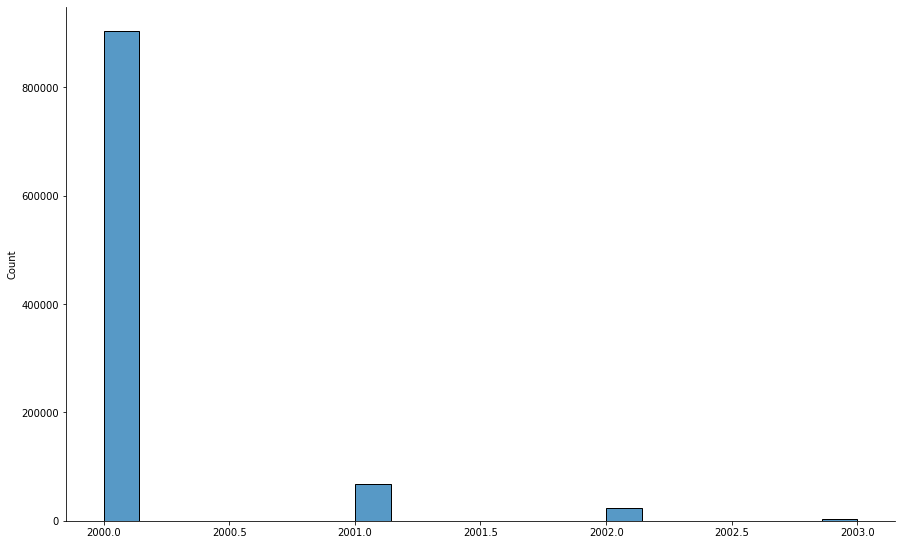

In [11]:
date = [datetime.datetime.fromtimestamp(rating['timestamp'][i]).date() for i in range(len(rating['timestamp']))]
g=sns.displot([i.year for i in date])
g.fig.set_size_inches(15,8)

Год также лидирует 2000. Но есть отличие в подборке анализируемых лет: в прошлый раз фильмы были собраны в куда большем диапазоне: с 1996 по 2018. Сейчас же представлены фильмы только за 4 года: с 2000 до 2003 включительно.

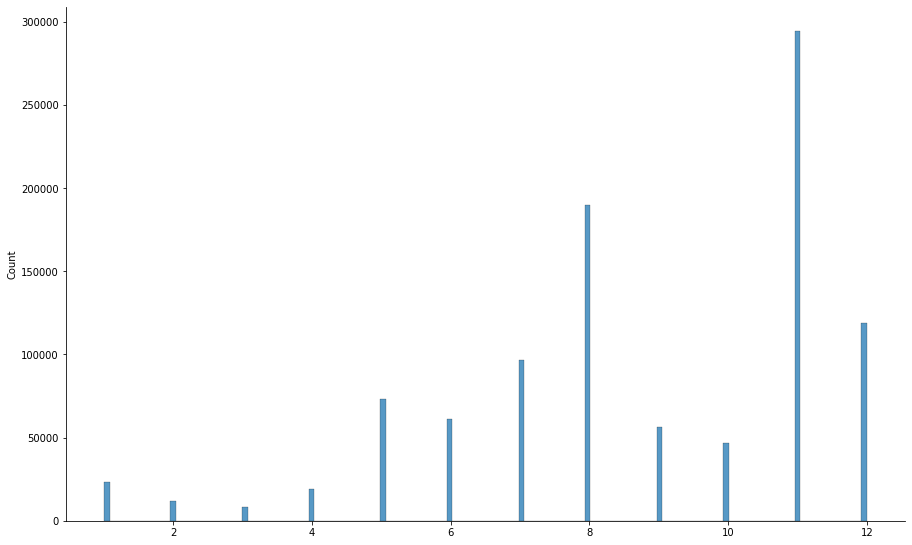

In [12]:
m=sns.displot([i.month for i in date])
m.fig.set_size_inches(15,8)

В связи с этим и месяцы тоже немного сдвинулись: ноябрь действительно остается лидером, но в прошлый раз не сильно ему уступал май. Сейчас же на втором месте август, а май занимает лишь 4 место по количеству выставленных оценок.  
Тем не менее, стоит вспомнить, что именно в 2000 году самым активным был месяц август. А т.к. 2000 год входит в эту подборку, то вполне возможно, что именно он и "перетянул" на себя эти оценки.

Идем дальше. У нас появился датасет users. Остановимся на нем:

gender


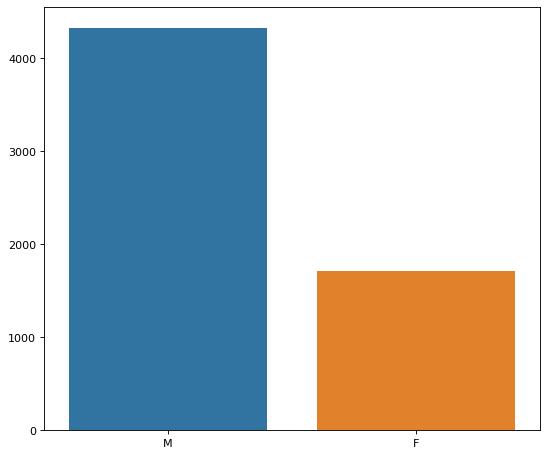

occupation


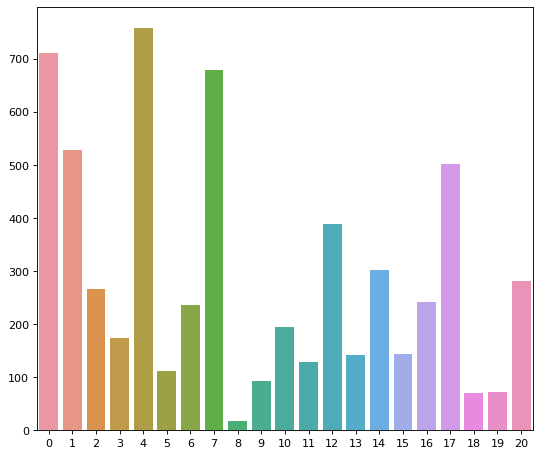

In [13]:
for i in ['gender', 'occupation']:
    print(i)
    plt.figure(figsize=(8, 7), dpi=80)
    sns.barplot(x=users[i].value_counts().index, y=users[i].value_counts().values)
    plt.show()

Что можно сказать: мужчины гораздо чаще ставили оценки, нежели чем женщины.  
Род занятости юзеров тоже разнится, но лидером является группа "студенты". На втором месте "другие" (те, кто не вошли ни в одну группу), завершают тройку "менеджеры".

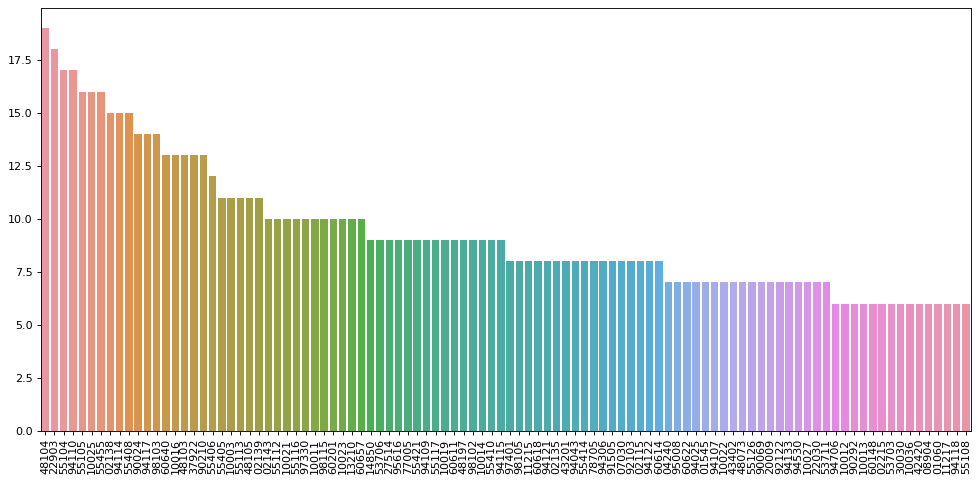

In [14]:
plt.figure(figsize=(15, 7), dpi=80)
sns.barplot(x=users['zip-code'].value_counts().index[:100], y=users['zip-code'].value_counts()[:100].values)
plt.xticks(rotation=90)
plt.show()

Согласно распределения индексов можно сказать, что есть области, где люди ставят оценки чаще. Поскольку мы не можем точно сказать, о каких конкретно районах идет речь, то дальше исползовать эту информацию смысла нет.

<AxesSubplot:xlabel='age', ylabel='Density'>

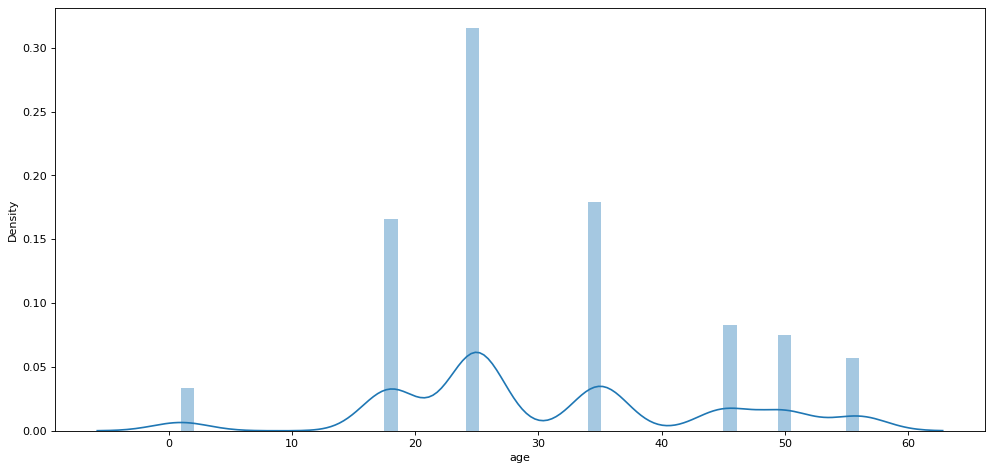

In [15]:
plt.figure(figsize=(15, 7), dpi=80)
sns.distplot(users['age'])

Чаще всего ставят оценки люди от 20 до 30 лет. Как правило, люди этого возраста и правда самые активные по части посещения кинопремьер.

Итак, небольшой анализ провели, идем дальше.

### Объединение таблиц

Поскольку в перспективе нам понадобится только id юзера, название фильма и его рейтинг, соединим 2 таблицы: movies и rating:

In [16]:
movies_with_ratings = movies.join(rating.set_index('movieId'), on='movieId').reset_index(drop=True)
movies_with_ratings.dropna(inplace=True)

In [17]:
movies_with_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1.0,5.0,978824268.0
1,1,Toy Story (1995),Animation|Children's|Comedy,6.0,4.0,978237008.0
2,1,Toy Story (1995),Animation|Children's|Comedy,8.0,4.0,978233496.0
3,1,Toy Story (1995),Animation|Children's|Comedy,9.0,5.0,978225952.0
4,1,Toy Story (1995),Animation|Children's|Comedy,10.0,5.0,978226474.0


In [18]:
movies_with_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000385
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   movieId    1000209 non-null  int64  
 1   title      1000209 non-null  object 
 2   genres     1000209 non-null  object 
 3   userId     1000209 non-null  float64
 4   rating     1000209 non-null  float64
 5   timestamp  1000209 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 53.4+ MB


Удалим жанры и id фильма:

In [19]:
movies_with_ratings = movies_with_ratings.drop(['movieId', 'genres'], axis=1)
movies_with_ratings

,title,userId,rating,timestamp
0,Toy Story (1995),1.0,5.0,9.788243e+08
1,Toy Story (1995),6.0,4.0,9.782370e+08
2,Toy Story (1995),8.0,4.0,9.782335e+08
3,Toy Story (1995),9.0,5.0,9.782260e+08
4,Toy Story (1995),10.0,5.0,9.782265e+08
...,...,...,...,...
1000381,"Contender, The (2000)",5812.0,4.0,9.920721e+08
1000382,"Contender, The (2000)",5831.0,3.0,9.862231e+08
1000383,"Contender, The (2000)",5837.0,4.0,1.011903e+09
1000384,"Contender, The (2000)",5927.0,1.0,9.798525e+08


Переименуем столбцы под нужды модели:

In [20]:
mov = pd.DataFrame({
    'uid': movies_with_ratings.userId,
    'iid': movies_with_ratings.title,
    'rating': movies_with_ratings.rating,
})

In [21]:
mov.head()

,uid,iid,rating
0,1.0,Toy Story (1995),5.0
1,6.0,Toy Story (1995),4.0
2,8.0,Toy Story (1995),4.0
3,9.0,Toy Story (1995),5.0
4,10.0,Toy Story (1995),5.0


Посмотрим на крайние значения рейтинга:

In [22]:
mov['rating'].min(), mov['rating'].max()

(1.0, 5.0)

Подставим этот интервал в переменную rating:

In [23]:
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(mov, reader)

Поделим выборку на тренировочную и тестовую:

In [24]:
trainset, testset = train_test_split(data, test_size=.15)

### Обучение моделей

In [25]:
%%time
algo = KNNWithMeans(k=75, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
CPU times: user 1min 31s, sys: 1.33 s, total: 1min 33s
Wall time: 1min 32s


In [26]:
test_pred = algo.test(testset)

In [27]:
accuracy.rmse(test_pred, verbose=True)

RMSE: 0.8892


0.8891722915442809

Итак, модель работает, обучение идет. Для достижения результата попробуем "поиграть" моделями и гиперпараметрами:

Используем теперь алгоритм SVD:

In [28]:
%%time
algo_1 = SVD()
algo_1.fit(trainset)

CPU times: user 1min 2s, sys: 58.7 ms, total: 1min 2s
Wall time: 1min 2s


In [29]:
test_pred_1 = algo_1.test(testset)
accuracy.rmse(test_pred_1, verbose=True)

RMSE: 0.8711


0.8710559294172576

В принципе, можно сказать, что мы победили, но, чтобы не притягивать результат, сделаем еще один шаг.

Переберем несколько алгоритмов, и, используя кросс-валидацию, выберем тот, который будет ошибаться меньше всего:

In [30]:
%%time
benchmark = []
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), 
                  KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False, n_jobs=-1) # используем cross validation
    
    # скомпонуем результаты и вставим название алгоритма:
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

CPU times: user 1min 28s, sys: 11.4 s, total: 1min 40s
Wall time: 1h 8min 43s


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.870617,2855.830639,141.835676
SVD,0.886289,47.884689,5.388264
KNNBaseline,0.899625,16.188658,178.356707
SlopeOne,0.908032,9.913693,93.406205
BaselineOnly,0.909886,0.463209,2.884492
CoClustering,0.916094,7.988392,3.671096
NMF,0.919008,41.778965,4.509160
KNNBasic,0.930990,16.603363,162.730133
KNNWithMeans,0.932798,16.612064,165.716103


In [39]:
%%time
algo_2 = SVDpp()
algo_2.fit(trainset)

CPU times: user 1h 28min 19s, sys: 4.87 s, total: 1h 28min 24s
Wall time: 4h 40min 15s


In [51]:
test_pred_2 = algo_2.test(testset)
accuracy.rmse(test_pred_2, verbose=True)

RMSE: 0.8598


0.8598291123962051

Итак, у нас появился победитель - SVDpp, но алгоритм обучается в разы дольше остальных. Поэтому возьмем второе значение - алгоритм SVD. Попробуем его усовершенствовать: применим GridSearchCV:

In [37]:
param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.4, 0.6, 0.2]}

In [44]:
%%time
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)

gs.fit(data)

table = [[] for _ in range(len(gs.cv_results['params']))]
for i in range(len(gs.cv_results['params'])):
    for key in gs.cv_results.keys():
        table[i].append(gs.cv_results[key][i])

header = gs.cv_results.keys()
print(tabulate(table, header, tablefmt="rst"))
print()

==================  ==================  ==================  ==================  ==================  ================  ===============  ================  ===============  ==============  ================  ===============  =================================================  ================  ==============  ===============
  split0_test_rmse    split1_test_rmse    split2_test_rmse    split3_test_rmse    split4_test_rmse    mean_test_rmse    std_test_rmse    rank_test_rmse    mean_fit_time    std_fit_time    mean_test_time    std_test_time  params                                               param_n_epochs    param_lr_all    param_reg_all
==================  ==================  ==================  ==================  ==================  ================  ===============  ================  ===============  ==============  ================  ===============  =================================================  ================  ==============  ===============
          0.942369            0.93

Не самая лучшая подача результата. Попробуем по-старинке:

In [47]:
gs.best_params

{'rmse': {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}}

Теперь проверим, как оно в деле:

In [48]:
%%time
algo_3 = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)
algo_3.fit(trainset)

CPU times: user 1min 3s, sys: 116 ms, total: 1min 3s
Wall time: 1min 3s


In [49]:
test_pred_3 = algo_3.test(testset)
accuracy.rmse(test_pred_3, verbose=True)

RMSE: 0.9176


0.9175929338715757

И всё равно результат оказался хуже, чем у SVDpp (RMSE: 0.8598). Поскольку результат этого алгоритма оказался лучше всех, остановимся на нем.

### Выводы

Цель данной работы - получить на тестовых данных RMSE не больше 0,87.  
Работа состояла из нескольких этапов:
- На первом этапе была предобработка данных и их анализ. Мы выяснили, что новый, расширенный, датасет не сильно отличается от предыдущего. Особое внимание было уделено новым столбцами и новому датафрейму - информации о юзерах.  
- Вторым этапом было объединение таблиц и подготовка к обучению моделей. По аналогии с прошлым разом мы отсеивали все ненужные столбцы и видоизменяли необходимые.  
- На заключительном, третьем, этапе в процессе обучения выяснилось, что наилучший результат показал алгоритм SVDpp, достигший результата RMSE=0.8598 на тестовых данных. Использование именно этого алгоритма одновременно и хорошая, и плохая идея. Хоть и результат оказался оправданным, обучение заняло огромное количество времени, что в условиях дедлайна может играть против нас. Поэтому в дальнейшем стоит еще посмотреть на другие алгоритмы, поискать оптимальные гиперпараметры и получить лучший результат. Соответственно, можно сказать, что это не предел, но цель задания достигнута, поэтому в данном случае работа окончена.